# 集成学习进阶-GBDT梯度提升树-参数空间与超参数优化

1. 不同的参数对算法结果都影响力大小
2. 确定用于搜索的参数空间

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import cross_val_score
# 导入优化算法
import hyperopt # pip install hyperopt
from hyperopt import hp,fmin, tpe, Trials, partial, STATUS_OK
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import train_test_split

In [25]:
from sklearn.datasets import load_iris
iris = load_iris()
X,y = iris.data, iris.target

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1210)
from sklearn.ensemble import RandomForestClassifier as RFC
# 定义一个参数空间
space = {
    'max_depth': hp.choice('max_depth', [None, 3,10,20,30,40,50]), # hp.choice从给定点选项中找一个
    # hp.uniform表示从给定范围均匀选择一个
    'min_samples_split': hp.uniform('min_samples_split',0,1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0,1),
    'n_estimators': hp.choice('n_estimators', [10,50,100,200]),    
}
# 定义目标函数,这个函数被用于评估不同的超参数组合
def objective(params):
    params = {
        'max_depth': int(params['max_depth']) if params['max_depth'] is not None else None,
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'n_estimators': params['n_estimators'],
    }
    model = RFC(**params, random_state=1210)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

In [52]:
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print('Best Parameters found', best_params)

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.67trial/s, best loss: -0.9583333333333334]
Best Parameters found {'max_depth': 4, 'min_samples_leaf': 0.05065874421371182, 'min_samples_split': 0.27406541389885647, 'n_estimators': 2}


## 基于TOE的GBDT超参数优化

In [53]:
data = pd.read_csv('./data/train_encode.csv',index_col=0)
X = data.iloc[:,:-1]
y= data.iloc[:,-1]

In [57]:
# 定义一个交叉验证方式,这里使用的是5折交叉验证,打乱数据
cv = KFold(n_splits=5, shuffle=True, random_state=1210)
# 定义一个计算绝对平均的RMSE
def RMSE(result, name):
    return abs(result[name].mean())
gbr = GBR(random_state=1210)
# 使用从ross_validate对模型进行评估
result_gbdt = cross_validate(gbr,  # 传递给模型的对象
               X,   # 特征变量的数据集
               y,    #  目标变量的数据集
               cv=cv,  # 交叉验证的分割厕所
               scoring='neg_root_mean_squared_error', # 负的均方根误差
               return_train_score=True, # 是否在叫超验证当中返回训练分数
               verbose=True, #控制输出的冗余程度
               n_jobs=-1, # 并行作业的数量
              )
# 计算误差
train_rmse = RMSE(result_gbdt, "train_score")
test_rmse = RMSE(result_gbdt, 'test_score')
print(f'训练集得分: {train_rmse}')
print(f"测试集得分: {test_rmse}")
print(f'平均训练耗时: {result_gbdt['fit_time'].mean()}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


训练集得分: 14073.455827917089
测试集得分: 26931.362456023093
平均训练耗时: 0.581626558303833


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


In [109]:
rfr = RFR(n_estimators=89, max_depth=22, max_features=14,min_impurity_decrease=0,
         random_state=1210, verbose=False, n_jobs=-1
         )

### 定义目标函数

In [110]:
def hyperopt_objective(params):
    rbg = GBR(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['lr'],
        criterion=params['criterion'],
        loss=params['loss'],
        max_depth=int(params['max_depth']),
        max_features=params['max_features'],
        min_impurity_decrease=params['min_impurity_decrease'],
        init=rfr,
        random_state=1210,
        verbose=False,
    )
    cv = KFold(n_splits=5,shuffle=True, random_state=1210)
    valiadtion_loss = cross_validate(
            rbg, X, y, scoring='neg_root_mean_squared_error',
            cv=cv,verbose=False,n_jobs=-1,error_score='raise',
    )
    mean_loss = np.mean(abs(valiadtion_loss['test_score']))
    return mean_loss

### 参数空间

In [111]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=1128)
from sklearn.ensemble import RandomForestClassifier as RFC
space={
    'max_depth':hp.choice('max_depth',[None,3,10,20,30,40,50]),
    'min_samples_split':hp.uniform('min_samples_split',0.0,1.0),
    'min_samples_leaf':hp.uniform('min_samples_leaf',0.0,1.0),
    'n_estimators':hp.choice('n_estimators',[10,50,100,200])
}

def objective(params):
    params={
        'max_depth':int(params['max_depth']) if params['max_depth'] is not None else None,
        'min_samples_split':params['min_samples_split'],
        'min_samples_leaf':params['min_samples_leaf'],
        'n_estimators':params['n_estimators']
    
    }
    model=RFC(**params,random_state=1128)
    score=cross_val_score(model,X_train,y_train,cv=5,scoring='accuracy').mean()
    return{'loss':-score,'status':STATUS_OK}

In [112]:
param = {
    'n_estimators': hp.quniform('n_estimators',25, 200, 25),
    "lr": hp.quniform('learning_rate',0.01,3.0, 0.05),
    'criterion': hp.choice('criterion',['friedman_mse','squared_error']),
    'loss': hp.choice("loss",['squared_error','absolute_error','huber','quantile']),
    'max_depth': hp.quniform('max_depth',2,30,2),
    'subsample': hp.quniform('subsample',0.1,0.8,0.1),
    'max_features': hp.choice("max_features", ['log2','sqrt',16,32,64]),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease',0,5,1)
} 

### 优化函数

In [113]:
def param_hyperopt(max_evals=200):
    trials = Trials()  # 保存每次迭代的结果
    early_stop_fn = no_progress_loss(50)  # 设置提前停止机制,如果连续50次都没改进,就停止

    best_params = fmin(
        fn=hyperopt_objective,  # 目标函数
        space=param,  # 参数空间
        algo=tpe.suggest,  # 使用TPE算法进行优化
        max_evals=max_evals,
        verbose=True,  # 关闭每次迭代的信息
        trials=trials,  # 记录每次迭代的信息
        early_stop_fn=early_stop_fn  # 提前停止机制,
    )
    print(f"Best Parameters found\n{best_params}")
    best_params['criterion'] = ['friedman_mse',
                                'squared_error'][best_params['criterion']]
    best_params['loss'] = [
        'squared_error', 'absolute_error', 'huber', 'quantile'
    ][best_params['loss']]
    best_params['max_features'] = ['log2','sqrt',16,32,64][best_params['max_features']]
    print(f"转换后的参数组合为: {best_params}")
    return best_params, trials

### 训练贝叶斯优化器

In [128]:
param_best, trials = param_hyperopt(300)

 69%|███████████████████████████████████████████████▏                    | 208/300 [07:20<03:14,  2.12s/trial, best loss: 26480.67464985185]


Best Parameters found
{'criterion': 1, 'learning_rate': 0.45, 'loss': 2, 'max_depth': 2.0, 'max_features': 2, 'min_impurity_decrease': 
0.0, 'n_estimators': 100.0, 'subsample': 0.5}

转换后的参数组合为: {'criterion': 'squared_error', 'learning_rate': 0.45, 'loss': 'huber', 'max_depth': 2.0, 
'max_features': 16, 'min_impurity_decrease': 0.0, 'n_estimators': 100.0, 'subsample': 0.5}

In [75]:
param_best

{'criterion': 'friedman_mse',
 'learning_rate': 0.55,
 'loss': 'huber',
 'max_depth': 2.0,
 'max_features': 64,
 'min_impurity_decrease': 4.0,
 'n_estimators': 125.0,
 'subsample': 0.1}

In [131]:
trials.results # 查看每次训练的损失结果
tb1 = pd.DataFrame([i['result'] for i in trials.trials])
tb1.columns = ['finall_loss', 'statues']
tb2 = pd.DataFrame([i['misc']['vals'] for i in trials.trials])
tb = pd.concat([tb1,tb2],axis=1)
tb[tb['finall_loss'] < 27000]

,finall_loss,statues,criterion,learning_rate,loss,max_depth,max_features,min_impurity_decrease,n_estimators,subsample
46,26744.351443,ok,[0],[0.35000000000000003],[2],[28.0],[2],[3.0],[25.0],[0.6000000000000001]
77,26939.598713,ok,[1],[0.4],[2],[20.0],[2],[3.0],[150.0],[0.8]
83,26792.876811,ok,[1],[0.25],[2],[28.0],[2],[2.0],[125.0],[0.8]
89,26705.548194,ok,[1],[0.4],[2],[28.0],[2],[3.0],[125.0],[0.8]
102,26973.884352,ok,[0],[0.75],[2],[28.0],[2],[4.0],[125.0],[0.8]
137,26598.158974,ok,[1],[0.2],[2],[4.0],[2],[0.0],[125.0],[0.4]
149,26809.645224,ok,[1],[0.4],[2],[10.0],[2],[1.0],[100.0],[0.30000000000000004]
157,26480.674650,ok,[1],[0.45],[2],[2.0],[2],[0.0],[100.0],[0.5]
161,26711.148564,ok,[1],[0.15000000000000002],[2],[4.0],[2],[0.0],[50.0],[0.5]
162,26652.320686,ok,[1],[0.4],[2],[4.0],[2],[0.0],[75.0],[0.1]


In [142]:
param = {
    'n_estimators': hp.quniform('n_estimators',125, 180, 5),
    "lr": hp.quniform('learning_rate',0.05,0.8, 0.05),
    'criterion': hp.choice('criterion',['squared_error']),
    'loss': hp.choice("loss",['huber']),
    'max_depth': hp.quniform('max_depth',2,30,1),
    'subsample': hp.quniform('subsample',0.5,1,0.05),
    'max_features': hp.choice("max_features", range(16,32,2)),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease',0,4,0.5)
}
def param_hyperopt(max_evals=200):
    trials = Trials()  # 保存每次迭代的结果
    early_stop_fn = no_progress_loss(50)  # 设置提前停止机制,如果连续50次都没改进,就停止

    best_params = fmin(
        fn=hyperopt_objective,  # 目标函数
        space=param,  # 参数空间
        algo=tpe.suggest,  # 使用TPE算法进行优化
        max_evals=max_evals,
        verbose=True,  # 关闭每次迭代的信息
        trials=trials,  # 记录每次迭代的信息
        early_stop_fn=early_stop_fn  # 提前停止机制,
    )
    print(f"Best Parameters found\n{best_params}")
    best_params['criterion'] = ['squared_error'][best_params['criterion']]
    best_params['loss'] = ['huber'][best_params['loss']]
    best_params['max_features'] = list(range(16,32,2))[best_params['max_features']]
    print(f"转换后的参数组合为: {best_params}")
    return best_params, trials

In [143]:
param_best, trials = param_hyperopt(300)

 22%|███████████████▍                                                     | 67/300 [02:25<08:27,  2.18s/trial, best loss: 26164.39904602347]


Best Parameters found
{'criterion': 0, 'learning_rate': 0.7000000000000001, 'loss': 0, 'max_depth': 15.0, 'max_features': 2, 
'min_impurity_decrease': 2.5, 'n_estimators': 135.0, 'subsample': 0.65}

转换后的参数组合为: {'criterion': 'squared_error', 'learning_rate': 0.7000000000000001, 'loss': 'huber', 
'max_depth': 15.0, 'max_features': 20, 'min_impurity_decrease': 2.5, 'n_estimators': 135.0, 'subsample': 0.65}

In [136]:
tb1 = pd.DataFrame([i['result'] for i in trials.trials])
tb1.columns = ['finall_loss', 'statues']
tb2 = pd.DataFrame([i['misc']['vals'] for i in trials.trials])
tb = pd.concat([tb1,tb2],axis=1)

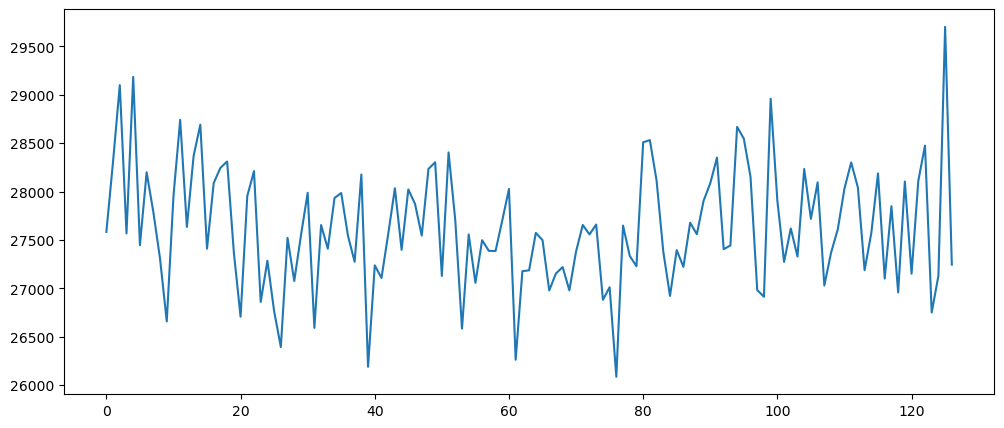

In [140]:
plt.figure(figsize=(12,5),dpi=100)
plt.plot(range(tb.shape[0]),tb['finall_loss'])
plt.show()

In [146]:
param = {
    'n_estimators': hp.quniform('n_estimators',125, 180, 2),
    "lr": hp.quniform('learning_rate',0.05,0.8, 0.05),
    'criterion': hp.choice('criterion',['squared_error']),
    'loss': hp.choice("loss",['huber']),
    'max_depth': hp.quniform('max_depth',2,30,1),
    'subsample': hp.quniform('subsample',0.2,1,0.02),
    'max_features': hp.choice("max_features",  list(range(16,32,2))),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease',0,4,0.01)
}
def param_hyperopt(max_evals=200):
    trials = Trials()  # 保存每次迭代的结果
    early_stop_fn = no_progress_loss(50)  # 设置提前停止机制,如果连续50次都没改进,就停止

    best_params = fmin(
        fn=hyperopt_objective,  # 目标函数
        space=param,  # 参数空间
        algo=tpe.suggest,  # 使用TPE算法进行优化
        max_evals=max_evals,
        verbose=True,  # 关闭每次迭代的信息
        trials=trials,  # 记录每次迭代的信息
        early_stop_fn=early_stop_fn  # 提前停止机制,
    )
    print(f"Best Parameters found\n{best_params}")
    best_params['criterion'] = ['squared_error'][best_params['criterion']]
    best_params['loss'] = ['huber'][best_params['loss']]
    best_params['max_features'] = list(range(16,32,2))[best_params['max_features']]
    print(f"转换后的参数组合为: {best_params}")
    return best_params, trials

In [147]:
param_best, trials = param_hyperopt(300)

 37%|█████████████████████████                                          | 112/300 [03:31<05:55,  1.89s/trial, best loss: 26110.335692311335]


Best Parameters found
{'criterion': 0, 'learning_rate': 0.15000000000000002, 'loss': 0, 'max_depth': 4.0, 'max_features': 0, 
'min_impurity_decrease': 1.99, 'n_estimators': 156.0, 'subsample': 0.92}

转换后的参数组合为: {'criterion': 'squared_error', 'learning_rate': 0.15000000000000002, 'loss': 'huber', 
'max_depth': 4.0, 'max_features': 16, 'min_impurity_decrease': 1.99, 'n_estimators': 156.0, 'subsample': 0.92}